
Papers 
https://arxiv.org/pdf/1606.05250.pdf SQUADv2 dataset
https://arxiv.org/pdf/1810.04805.pdf BERT paper -- Given how large the model is we'll be looking at fine tuning only the portion related to question answering 

In [1]:
#!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install transformers==3.0.2
# !pip install wget
#!pip install torch===1.5.0 -f https://download.pytorch.org/whl/torch_stable.html --user

In [2]:
import requests
import json
import torch
import os
from tqdm import tqdm

In [3]:
torch.__version__

'1.5.0'

# Data Prep

In [4]:
!python -m wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!python -m wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json


Saved under train-v2.0 (17).json

Saved under dev-v2.0 (17).json


In [5]:
# Load the training dataset and take a look at it
with open('train-v2.0.json', 'rb') as f:
    squad = json.load(f)
squad['data'][0].keys()

dict_keys(['title', 'paragraphs'])

In [6]:
squad['data'][0]['paragraphs'][0]['context']

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [7]:
def read_data(path):  
    # load the json file
    with open(path, 'rb') as f:
        squad = json.load(f)

    contexts = []
    questions = []
    answers = []

    for group in squad['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

In [8]:
train_contexts, train_questions, train_answers = read_data('train-v2.0.json')
valid_contexts, valid_questions, valid_answers = read_data('dev-v2.0.json')

In [9]:
print(f'There are {len(train_questions)} questions')
print(train_questions[-10000])
print(train_answers[-10000])

There are 86821 questions
What is a modern common occurence with antibiotics?
{'text': 'resistance of bacteria', 'answer_start': 17}


In [10]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two so we fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)

In [11]:
print(train_questions[-10000])
print(train_answers[-10000])

What is a modern common occurence with antibiotics?
{'text': 'resistance of bacteria', 'answer_start': 17, 'answer_end': 39}


## Tokenization 

In [12]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)
train_encodings.keys()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 86821 context-question pairs


In [14]:
#Test ability to convert back to text 
#tokenizer.decode(train_encodings['input_ids'][0])

In [15]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
        
        if start_positions[-1] is None:
            start_positions[-1] = len(encodings['input_ids'][i])  # replace with maximum sequence length
        
        go_back = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end']-go_back)
            go_back += 1
            
    # remove any NoneType from the tensors
    start_positions = [pos if pos is not None else 0 for pos in start_positions]
    end_positions = [pos if pos is not None else 0 for pos in end_positions]
    
    encodings.update({
        'start_positions': start_positions,
        'end_positions' : end_positions
    })

add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)

In [16]:
class SQuAD_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) if val[idx] is not None else None for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [17]:
train_dataset = SQuAD_Dataset(train_encodings)
valid_dataset = SQuAD_Dataset(valid_encodings)

In [18]:
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

In [19]:
from torch.utils.data import DataLoader
batch_size = 4
# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

## Reset GPU 

In [20]:
print("GPU Available:\t"+str(torch.cuda.is_available()))
print("GPU Count:\t"+str(torch.cuda.device_count()))
print("GPU Name:\t"+str(torch.cuda.get_device_name()))
 
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

GPU Available:	True
GPU Count:	1
GPU Name:	NVIDIA GeForce RTX 2080
torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [21]:
import gc
torch.cuda.empty_cache()
gc.collect()

329

## Fine Tuning 

In [22]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [23]:
# Check on the available device - use GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cuda


In [24]:
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [25]:
#Validate model is saved on GPU 
torch.cuda.reset_peak_memory_stats() #Reset GPU Memory usage
print("GPU Memory Reset")
print(torch.cuda.memory_summary())

GPU Memory Reset
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  426474 KB |  426474 KB |  426474 KB |       0 B  |
|       from large pool |  425984 KB |  425984 KB |  425984 KB |       0 B  |
|       from small pool |     490 KB |     490 KB |     490 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  426474 KB |  426474 KB |  426474 KB |       0 B  |
|       from large pool |  425984 KB |  425984 

We fine-tuned for 2 epochs with a learning rate of 5e-5 and a batch size of 48.
    Jacob Devlin BERT SQUAD2 parameters 
    
    
Due to a limitation in my GPU memory size we maxed out the batch size at 4; however, triled to componsate by extending the epochs from 5 to 15. 

In [39]:
from transformers import AdamW

N_EPOCHS = 5
optim = AdamW(model.parameters(), lr=5e-5)


model.train()
train_losses = []
train_accs = []
for epoch in range(N_EPOCHS):
    loop = tqdm(train_loader, leave=True)
    
    running_loss = 0.0
    running_corrects = 0
    
    for batch in loop:
        if batch is None:
            continue
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()

        # Compute the batch accuracy
        logits = outputs[1]
        _, preds = torch.max(logits, 1)
        corrects = torch.sum(preds == end_positions)
        acc = corrects.double() / end_positions.size(0)
        
        # Record the batch loss and accuracy
        running_loss += loss.item() * input_ids.size(0)
        running_corrects += corrects
        train_losses.append(loss.item())
        train_accs.append(acc.item())
        
        #Visualize progress bar 
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item(), acc=acc.item())
        
    # Compute the epoch loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    # Print the epoch loss and accuracy
    print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

Epoch 0: 100%|█████████████████████████████████████████████| 21706/21706 [1:30:02<00:00,  4.02it/s, acc=0, loss=0.0706]


Epoch 1 Loss: 1.0393 Acc: 0.1098


Epoch 1: 100%|██████████████████████████████████████████████| 21706/21706 [1:29:38<00:00,  4.04it/s, acc=0, loss=0.367]


Epoch 2 Loss: 0.8655 Acc: 0.1150


Epoch 2: 100%|█████████████████████████████████████████████| 21706/21706 [1:27:11<00:00,  4.15it/s, acc=1, loss=0.0481]


Epoch 3 Loss: 0.7505 Acc: 0.1168


Epoch 3: 100%|█████████████████████████████████████████████| 21706/21706 [1:27:17<00:00,  4.14it/s, acc=0, loss=0.0169]


Epoch 4 Loss: 0.6625 Acc: 0.1194


Epoch 4: 100%|████████████████████████████████████████████| 21706/21706 [1:27:08<00:00,  4.15it/s, acc=0, loss=0.00607]

Epoch 5 Loss: 0.5909 Acc: 0.1206


In [40]:
model_path = 'model/3-4-23_bert-base-uncased_custom_epochs-'+str(N_EPOCHS)
os.mkdir(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('model/3-4-23_bert-base-uncased_custom_epochs-5\\tokenizer_config.json',
 'model/3-4-23_bert-base-uncased_custom_epochs-5\\special_tokens_map.json',
 'model/3-4-23_bert-base-uncased_custom_epochs-5\\vocab.txt',
 'model/3-4-23_bert-base-uncased_custom_epochs-5\\added_tokens.json',
 'model/3-4-23_bert-base-uncased_custom_epochs-5\\tokenizer.json')

In [41]:
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [42]:
#Load model
#from transformers import BertForQuestionAnswering, BertTokenizerFast

#model_path = 'model/bert-base-uncased_custom_epochs-'+str(epochs)
#model = BertForQuestionAnswering.from_pretrained(model_path)
#tokenizer = BertTokenizerFast.from_pretrained(model_path)

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#print(f'Working on {device}')

#model = model.to(device)

## Training Curve 

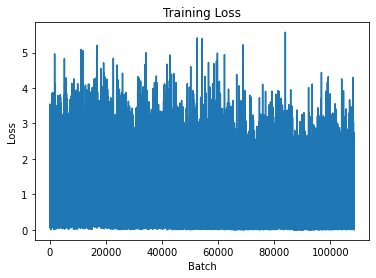

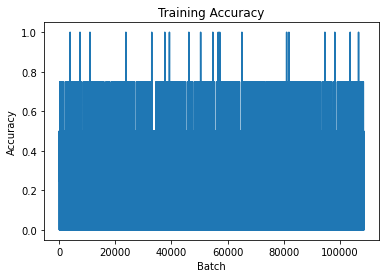

In [43]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy curves
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(train_accs)
plt.title("Training Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

## Validation Accuracy 

In [44]:
acc = []
true_positives = 0
false_positives = 0
false_negatives = 0

for batch in tqdm(val_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        loss = outputs[0]

        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        # Calculate the accuracy
        start_acc = ((start_pred == start_true.flatten()).sum().float() / len(start_pred)).item()
        end_acc = ((end_pred == end_true.flatten()).sum().float() / len(end_pred)).item()

        # Calculate the F1 score
        for i in range(len(start_true)):
            true_start = start_true[i].item()
            true_end = end_true[i].item()
            pred_start = start_pred[i].item()
            pred_end = end_pred[i].item()

            true_span = set(range(true_start, true_end + 1))
            pred_span = set(range(pred_start, pred_end + 1))

            tp = len(true_span & pred_span)
            fp = len(pred_span - true_span)
            fn = len(true_span - pred_span)

            true_positives += tp
            false_positives += fp
            false_negatives += fn

        #val_losses.append(loss.item())
        acc.append(start_acc)
        acc.append(end_acc)

aveValAcc = sum(acc)/len(acc)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Validation Accuracy:\t%.2f%%" % (100 * aveValAcc))
print("Validation F1 Score:\t%.2f%%" % (100 * f1_score))


100%|██████████████████████████████████████████████████████████████████████████████| 1269/1269 [06:00<00:00,  3.52it/s]

Validation Accuracy:	62.84%
Validation F1 Score:	58.84%


Bert Large archieved 83 F1 score

The main difference between the BERT-Base-Uncased and BERT-Large-Uncased models on Hugging Face is their size and number of parameters. BERT-Large-Uncased has more layers and parameters than BERT-Base-Uncased, which means it can handle more complex tasks and may provide better performance on some natural language processing (NLP) tasks, especially those that require a deeper understanding of the text.

Specifically, BERT-Base-Uncased has 12 transformer layers, 768 hidden units, and 110 million parameters, while BERT-Large-Uncased has 24 transformer layers, 1024 hidden units, and 340 million parameters.

However, BERT-Large-Uncased requires more memory and computing resources, and may take longer to train than BERT-Base-Uncased. Therefore, BERT-Base-Uncased is often a good choice for smaller datasets or when you have limited computing resources, while BERT-Large-Uncased may be more suitable for large-scale NLP applications.

Therefore, we will have to accept some supbar performance given the limitations of my setup 

## Confusion Matrix 

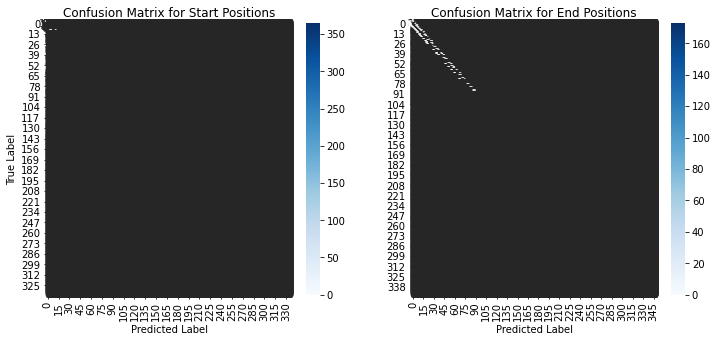

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create empty lists for true and predicted start and end positions
start_true, end_true, start_pred, end_pred = [], [], [], []

# Loop through the validation set and predict start and end positions
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true_batch = batch['start_positions'].to(device)
        end_true_batch = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        start_pred_batch = torch.argmax(outputs['start_logits'], dim=1)
        end_pred_batch = torch.argmax(outputs['end_logits'], dim=1)

        start_true += start_true_batch.cpu().tolist()
        end_true += end_true_batch.cpu().tolist()
        start_pred += start_pred_batch.cpu().tolist()
        end_pred += end_pred_batch.cpu().tolist()

# Compute the confusion matrix
cm_start = confusion_matrix(start_true, start_pred)
cm_end = confusion_matrix(end_true, end_pred)

# Plot the confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.heatmap(cm_start, annot=True, cmap='Blues', fmt='g', ax=axes[0])
sns.heatmap(cm_end, annot=True, cmap='Blues', fmt='g', ax=axes[1])
axes[0].set_title('Confusion Matrix for Start Positions')
axes[1].set_title('Confusion Matrix for End Positions')
axes[0].set_xlabel('Predicted Label')
axes[1].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
plt.show()

## Pred vs Actual Histogram 

C:\Users\vikto\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vikto\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vikto\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 23578 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vikto\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vikto\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 30465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vikto\AppData\Roaming\Pyth

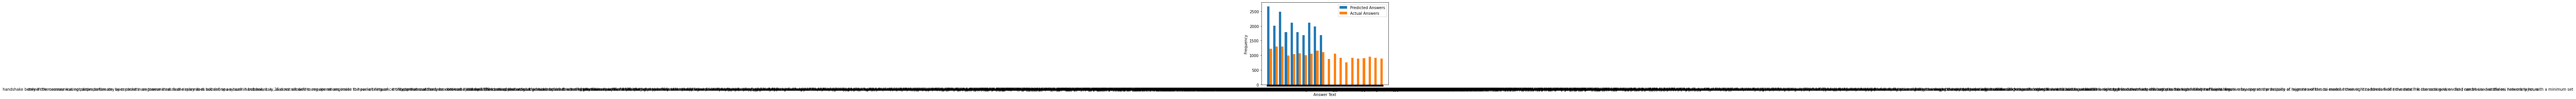

In [46]:
import numpy as np 
# Initialize empty lists to store predicted and actual answers
predicted_answers = []
actual_answers = []

# Iterate over the batches
for batch in val_loader:
    # Move the batch to the GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    # Get the model's predictions for the current batch
    with torch.no_grad():
        outputs = model(**batch)
        start_logits, end_logits = outputs.start_logits, outputs.end_logits

    # Convert logits to probabilities
    start_probs = torch.softmax(start_logits, dim=1).cpu().numpy()
    end_probs = torch.softmax(end_logits, dim=1).cpu().numpy()

    # Get the predicted start and end positions
    start_pred, end_pred = np.argmax(start_probs, axis=1), np.argmax(end_probs, axis=1)

    # Get the true start and end positions
    start_true, end_true = batch['start_positions'].cpu().numpy(), batch['end_positions'].cpu().numpy()

    # Convert the predicted and actual answers to text
    for i in range(len(start_pred)):
        predicted_answer = tokenizer.decode(batch['input_ids'][i][start_pred[i]:end_pred[i]+1], skip_special_tokens=True)
        actual_answer = tokenizer.decode(batch['input_ids'][i][start_true[i]:end_true[i]+1], skip_special_tokens=True)
        predicted_answers.append(predicted_answer)
        actual_answers.append(actual_answer)
        
# Plot the histogram
fig, ax = plt.subplots()
ax.hist([predicted_answers, actual_answers], bins=20, label=['Predicted Answers', 'Actual Answers'])
ax.legend(loc='upper right')
ax.set_xlabel('Answer Text')
ax.set_ylabel('Frequency')
plt.show()

## Question Demo 

In [47]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    outputs = model(**inputs)

    answer_start = torch.argmax(outputs[0])  
    answer_end = torch.argmax(outputs[1]) + 1 

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return round(2 * (prec * rec) / (prec + rec), 2)
  
def question_answer(context, question,answer):
    prediction = get_prediction(context,question)
    em_score = exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)

    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answer}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {f1_score}\n')

In [48]:
#Beyonce
context = """Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, 
          songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing 
          and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. 
          Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. 
          Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, 
          earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy"."""


questions = ["For whom the passage is talking about?",
             "When did Beyonce born?",
             "Where did Beyonce born?",
             "What is Beyonce's nationality?",
             "Who was the Destiny's group manager?",
             "What name has the Beyoncé's debut album?",
             "How many Grammy Awards did Beyonce earn?",
             "When did the Beyoncé's debut album release?",
             "Who was the lead singer of R&B girl-group Destiny's Child?"]

answers = ["Beyonce Giselle Knowles - Carter", "September 4, 1981", "Houston, Texas", 
           "American", "Mathew Knowles", "Dangerously in Love", "five", "2003", 
           "Beyonce Giselle Knowles - Carter"]

for question, answer in zip(questions, answers):
    question_answer(context, question, answer)

Question: For whom the passage is talking about?
Prediction: five grammy awards
True Answer: Beyonce Giselle Knowles - Carter
Exact match: False
F1 score: 0

Question: When did Beyonce born?
Prediction: 2003 )
True Answer: September 4, 1981
Exact match: False
F1 score: 0

Question: Where did Beyonce born?
Prediction: houston, texas,
True Answer: Houston, Texas
Exact match: True
F1 score: 1.0

Question: What is Beyonce's nationality?
Prediction: american
True Answer: American
Exact match: True
F1 score: 1.0

Question: Who was the Destiny's group manager?
Prediction: her father, mathew knowles,
True Answer: Mathew Knowles
Exact match: False
F1 score: 0.67

Question: What name has the Beyoncé's debut album?
Prediction: dangerously in love
True Answer: Dangerously in Love
Exact match: True
F1 score: 1.0

Question: How many Grammy Awards did Beyonce earn?
Prediction: five
True Answer: five
Exact match: True
F1 score: 1.0

Question: When did the Beyoncé's debut album release?
Prediction: 200

## User Question Demo 

We can test this section by adding in the context of a pdf, from ther we can define a set of questions and review what answers it provides. 

There maybe a limit to how long the context can be so we might want to denote that 

In [50]:
#Context -- pdf text 
#Question -- User input 
#Answer -- None 
#Performance output -- dont show 
prediction = get_prediction(context,question)